#### Main project notebook  
This notebook uses the other modules in the repository in order to train from scratch 3 different Resnets and compare their performance.  
It's important to note that the final accuracy results is affected by the different hyperparameters used in the training process, so it's possible to obtain better results by improving them, this are simply the ones i found to work best for me.

In [2]:
#Importing relevant libraries and files
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from math import floor
from Resnet_18_34 import *
from Resnet_50 import *

device = 'cuda' if torch.cuda.is_available() else 'cpu' #checking for gpu availability
dtype = torch.float32
print_every = 100

In [5]:
#Loading and preprocssing the CIFAR-10 Dataset
data_root = r'C:\Users\matan\Desktop\MLDL_Projects\Resnet\Cifar-10'
NUM_TRAIN = 49000

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

cifar10_train = dset.CIFAR10(root=data_root, train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(root=data_root, train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(root=data_root, train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

labels_dic = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
#Defining functions that will be used for training the model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc
    
def training_loop(model, optimizer, epochs=1, decay= False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    step = 0
    for e in range(epochs):
        print(f"Starting epoch {e + 1}")

        for t, (x, y) in enumerate(loader_train):
            model.train()                         # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)                     #scores are the logits which are the output of the model
            loss = F.cross_entropy(scores, y)     #This applies softmax on the logits as well as cross entropy loss function

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            val_acc = check_accuracy(loader_val, model)
            # Writing to tensorboard 
            writer.add_scalar('Training loss', loss, global_step= step)
            writer.add_scalar('Validation Accuracy', val_acc , global_step= step)
            step += 1

            if t % print_every == 0:
                print(f'Iteration {t}, training loss = {loss.item():.4f}')
                print(f'Validation set accuracy is : {100*val_acc:.2f}%')
                print()

        if decay==True:
          scheduler.step()

#### Resnet18 Model

In [7]:
#Initializing model and viewing architecture
model_18 = ResNet18(in_channels= 3, layer0=Layer0, resblock=ResBlock, final_layer=Final_layer, num_classes= 10).to(device)
summary(model_18, input_size= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Layer0-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
          ResBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
         ResBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14          [-1, 128,

In [6]:
writer = SummaryWriter(f'TB/model_18')
optimizer = optim.Adam(model_18.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.85)  # lr decay every epoch

training_loop(model_18, optimizer, epochs=10, decay=True) 

Starting epoch 1
Iteration 0, training loss = 2.3391
Validation set accuracy is : 9.80%

Iteration 100, training loss = 1.7083
Validation set accuracy is : 39.80%

Iteration 200, training loss = 1.4068
Validation set accuracy is : 47.70%

Iteration 300, training loss = 1.3830
Validation set accuracy is : 47.90%

Iteration 400, training loss = 1.3576
Validation set accuracy is : 42.50%

Iteration 500, training loss = 1.0302
Validation set accuracy is : 58.60%

Iteration 600, training loss = 1.1637
Validation set accuracy is : 63.50%

Iteration 700, training loss = 0.9105
Validation set accuracy is : 63.10%

Starting epoch 2
Iteration 0, training loss = 1.1451
Validation set accuracy is : 60.20%

Iteration 100, training loss = 1.0219
Validation set accuracy is : 67.30%

Iteration 200, training loss = 1.0713
Validation set accuracy is : 71.40%

Iteration 300, training loss = 0.8833
Validation set accuracy is : 65.90%

Iteration 400, training loss = 0.6891
Validation set accuracy is : 65.3

#### Resnet34 Model

In [8]:
model_34 = ResNet34(in_channels= 3, layer0=Layer0, resblock=ResBlock, final_layer=Final_layer, num_classes= 10).to(device)
summary(model_34, input_size= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Layer0-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
          ResBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
         ResBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [8]:
writer = SummaryWriter(f'TB/model_34')
learning_rate = 1e-3
optimizer = optim.Adam(model_34.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.85)  # lr decay every epoch

training_loop(model_34, optimizer, epochs=10, decay=True)

Starting epoch 1
Iteration 0, training loss = 2.5676
Validation set accuracy is : 11.20%

Iteration 100, training loss = 1.7671
Validation set accuracy is : 27.50%

Iteration 200, training loss = 1.6446
Validation set accuracy is : 45.40%

Iteration 300, training loss = 1.5551
Validation set accuracy is : 42.90%

Iteration 400, training loss = 1.1399
Validation set accuracy is : 48.90%

Iteration 500, training loss = 1.3526
Validation set accuracy is : 53.40%

Iteration 600, training loss = 1.0464
Validation set accuracy is : 52.30%

Iteration 700, training loss = 1.0433
Validation set accuracy is : 54.80%

Starting epoch 2
Iteration 0, training loss = 1.0382
Validation set accuracy is : 51.60%

Iteration 100, training loss = 1.0513
Validation set accuracy is : 62.00%

Iteration 200, training loss = 1.1114
Validation set accuracy is : 64.90%

Iteration 300, training loss = 0.7560
Validation set accuracy is : 61.70%

Iteration 400, training loss = 0.8832
Validation set accuracy is : 65.

#### Resnet50 Model

In [9]:
model_50 = ResNet50(in_channels= 3, layer0=Layer0, bottleneckblock=BottleneckBlock, final_layer=Final_layer, num_classes= 10).to(device)
summary(model_50, input_size= (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,864
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Layer0-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 256, 32, 32]          16,640
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6           [-1, 64, 32, 32]           4,160
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]          36,928
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 256, 32, 32]          16,640
      BatchNorm2d-11          [-1, 256, 32, 32]             512
  BottleneckBlock-12          [-1, 256, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          16,448
      BatchNorm2d-14           [-1, 64,

In [5]:
writer = SummaryWriter(f'TB/model_50')
learning_rate = 1e-3
optimizer= optim.Adam(model_50.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)  # lr decay every epoch

training_loop(model_50, optimizer, epochs=10, decay= True)
torch.save(model_50.state_dict(), "model_50_saved.pth")

Starting epoch 1
Iteration 0, training loss = 2.5998
Validation set accuracy is : 10.80%

Iteration 100, training loss = 1.7053
Validation set accuracy is : 36.90%

Iteration 200, training loss = 1.6747
Validation set accuracy is : 42.90%

Iteration 300, training loss = 1.5991
Validation set accuracy is : 44.40%

Iteration 400, training loss = 1.3627
Validation set accuracy is : 43.30%

Iteration 500, training loss = 1.4050
Validation set accuracy is : 49.80%

Iteration 600, training loss = 1.2601
Validation set accuracy is : 47.40%

Iteration 700, training loss = 1.1633
Validation set accuracy is : 57.70%

Starting epoch 2
Iteration 0, training loss = 1.2004
Validation set accuracy is : 46.80%

Iteration 100, training loss = 0.8140
Validation set accuracy is : 65.70%

Iteration 200, training loss = 0.9901
Validation set accuracy is : 63.90%

Iteration 300, training loss = 0.9632
Validation set accuracy is : 65.20%

Iteration 400, training loss = 0.6865
Validation set accuracy is : 66.

#### Summary, Comparison and Inferece

In [10]:
#Loading saved models
model_18.load_state_dict(torch.load("model_18_saved.pth"))
model_34.load_state_dict(torch.load("model_34_saved.pth")) 
model_50.load_state_dict(torch.load("model_50_saved.pth")) 

<All keys matched successfully>

In [12]:
#Comparing models accuracies on test set
test_acc_model18 = check_accuracy(loader_test, model_18)
test_acc_model34 = check_accuracy(loader_test, model_34)
test_acc_model50 = check_accuracy(loader_test, model_50)

print(f"Resnet 18 test acc: {100*test_acc_model18:.2f}%")
print(f"Resnet 34 test acc: {100*test_acc_model34:.2f}%")
print(f"Resnet 50 test acc: {100*test_acc_model50:.2f}%")

Resnet 18 test acc: 84.13%
Resnet 34 test acc: 84.50%
Resnet 50 test acc: 81.14%


Now after testing the model's we can choose the best one, in this case Resnet34, and use it to sample images from the test set and see how it performs.

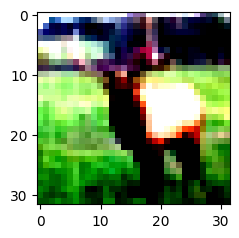

True label: deer | Model's prediction label: deer


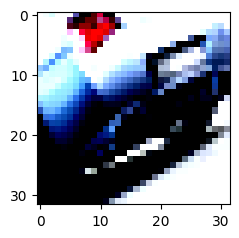

True label: automobile | Model's prediction label: airplane


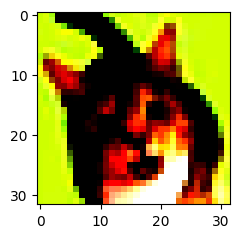

True label: cat | Model's prediction label: cat


In [120]:
#Random sampling from test set
def sample_test(model, num_samples=1):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            x , y = cifar10_test[floor(random.random()*len(cifar10_test))]
            true_label = labels_dic[y]
            x = x.unsqueeze(0).to(device)
            logits = model(x)
            _, y_pred = logits.max(1)
            pred_label = labels_dic[y_pred.item()]
            x = x.squeeze().cpu().permute(1,2,0).clamp(0,1)
            plt.figure(figsize=(2.5,2.5))
            plt.imshow(x)
            plt.show()
            print(f"True label: {true_label} | Model's prediction label: {pred_label}")

sample_test(model_34, num_samples=3)            